In [2]:
# import absl.logging
# absl.logging.set_verbosity(absl.logging.ERROR)

import tensorflow as tf
from tensorflow import keras
# import tensorflow_addons as tfa
import pickle

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from sklearn import metrics
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

2.18.0


In [3]:
#!pip install scikeras
from sklearn import metrics,linear_model, svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, BayesianRidge, Lasso, RidgeCV, LassoCV, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score, mean_absolute_error, f1_score
import xgboost as xgb

In [4]:
df_348 = pd.read_excel("Results_Mismatch/withDescriptors_DFT_D3_ACS_AMI_348_hetero_Lattice_Mismatch.xlsx",'from_plots')

In [5]:
df_347 = df_348[abs(df_348['MBT_mismatch']) <=4]

In [6]:
X = df_347.iloc[:,21:]
y = df_347['MBT_mismatch']

In [7]:
Xy = pd.concat([X,y],axis=1)

In [16]:
import tensorflow as tf
import optuna
import numpy as np
from tensorflow.keras import layers, regularizers
from sklearn.metrics import r2_score
import random

train_val_dataset = Xy.sample(frac = 0.8, random_state = 42)
train_dataset = train_val_dataset.sample(frac = 0.75, random_state = 42)
val_dataset = train_val_dataset.drop(train_dataset.index)
test_dataset = Xy.drop(train_val_dataset.index)

train_data = np.copy(train_dataset)
val_data = np.copy(val_dataset)
test_data = np.copy(test_dataset)

train_data = pd.DataFrame(train_data)
val_data = pd.DataFrame(val_data)
test_data = pd.DataFrame(test_data)

X_train = train_data.drop([63],axis='columns')
X_val = val_data.drop([63],axis='columns')
X_test = test_data.drop([63],axis='columns')

y_train = train_data[63]
y_val = val_data[63]
y_test = test_data[63]


def objective(trial):

    hidden_layer_1  = trial.suggest_categorical('hidden_1', [100, 64])
    hidden_layer_2 = trial.suggest_categorical('hidden_2', [128, 64, 50, 32])
    hidden_layer_3 = trial.suggest_categorical('hidden_3', [64, 32, 20, 16])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.0, 0.1, 0.2])
    reg_type = trial.suggest_categorical('reg_type', ['None', 'L1', 'L2'])
    reg_strength = trial.suggest_categorical('reg_strength', [1e-5, 1e-4, 1e-3, 1e-2]) if reg_type != 'None' else 0.0
    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 5e-3, 1e-2])
    activation_type = trial.suggest_categorical('activation', ['relu', 'elu', 'selu'])

    SEED = 42
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(X_train))
    
    if reg_type == 'L1':
        reg = regularizers.l1(reg_strength)
    elif reg_type == 'L2':
        reg = regularizers.l2(reg_strength)
    else:
        reg = None  # No regularization  

    model = tf.keras.Sequential([normalizer])

    model.add(layers.Dense(hidden_layer_1, activation=activation_type, kernel_regularizer=reg))
    model.add(layers.Dropout(dropout_rate, seed=SEED))
    model.add(layers.Dense(hidden_layer_2, activation=activation_type, kernel_regularizer=reg))
    model.add(layers.Dropout(dropout_rate, seed=SEED))
    model.add(layers.Dense(hidden_layer_3, activation=activation_type, kernel_regularizer=reg))
    model.add(layers.Dropout(dropout_rate, seed=SEED))
    model.add(layers.Dense(1))  

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_absolute_error')

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, verbose=0, shuffle=False)

    # Return best validation loss
    # return min(history.history['val_loss'])

    # Return best R2 scores
    r2_train = r2_score(y_train, model.predict(X_train).flatten())
    r2_val = r2_score(y_val, model.predict(X_val).flatten())
    r2_test = r2_score(y_test, model.predict(X_test).flatten())
    return r2_train,r2_val,r2_test

# Run Optuna optimization
#study = optuna.create_study(direction='minimize') # for minimizing loss
study = optuna.create_study(directions=['maximize','maximize','maximize']) # for maximizing R2
study.optimize(objective, n_trials=300)

[I 2025-03-22 21:47:08,204] A new study created in memory with name: no-name-a5042ce0-f615-4a4a-a026-8acddb56335a


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 21:48:07,849] Trial 0 finished with values: [0.9635771260116268, 0.8083329826849344, 0.6913055221444926] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 21:48:57,573] Trial 1 finished with values: [0.9915272871038737, 0.8068719925872696, 0.7518846525139657] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 21:49:43,905] Trial 2 finished with values: [0.9739551713754789, 0.8267549683757065, 0.744125347265473] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-22 21:50:29,722] Trial 3 finished with values: [0.9954963836045563, 0.8315145608661092, 0.7504444327722639] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-22 21:51:17,139] Trial 4 finished with values: [0.9580628609402796, 0.8245535790760807, 0.7592317665195727] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 21:52:04,578] Trial 5 finished with values: [0.9496980655138828, 0.8464421016123855, 0.6894731010517381] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-22 21:52:52,170] Trial 6 finished with values: [0.9130679637427555, 0.8049239176128039, 0.6596151846724576] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 21:53:40,072] Trial 7 finished with values: [0.9966873604247721, 0.8218821251849151, 0.69735902604808] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 21:54:27,891] Trial 8 finished with values: [0.9679762247237057, 0.8292728057642641, 0.7517712932497169] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-22 21:55:15,197] Trial 9 finished with values: [0.9594892225765846, 0.8086907383082361, 0.6930715711405796] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 21:56:01,113] Trial 10 finished with values: [0.9559766104290506, 0.7978448106962761, 0.6685372596387749] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-22 21:56:48,531] Trial 11 finished with values: [0.9355660748273427, 0.8129282697501958, 0.7439244127671827] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 21:57:36,584] Trial 12 finished with values: [0.9865762628823205, 0.8009065574852254, 0.7190728133382345] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 21:58:24,432] Trial 13 finished with values: [0.9712942596615909, 0.8578283770883233, 0.7287178739505433] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 21:59:11,533] Trial 14 finished with values: [0.9297992725482009, 0.8163154388253921, 0.6395302764125393] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-22 21:59:58,344] Trial 15 finished with values: [0.9886932734271784, 0.8290710432598009, 0.7383769163954998] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-22 22:00:44,550] Trial 16 finished with values: [0.9952035616163569, 0.8010547880558616, 0.7267023371043324] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-22 22:01:32,622] Trial 17 finished with values: [0.8600301422136458, 0.7973173018338229, 0.7114840854328448] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:02:19,142] Trial 18 finished with values: [0.9942971357686489, 0.8228544582575938, 0.6841844585242862] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-22 22:03:07,181] Trial 19 finished with values: [0.9664107427260749, 0.8371373563383429, 0.6987594558517487] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:03:53,706] Trial 20 finished with values: [0.9969656224451168, 0.8163961292463275, 0.7281933214368113] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-22 22:04:41,708] Trial 21 finished with values: [0.9624771887267988, 0.8183008225429568, 0.6955977575080666] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-22 22:05:29,931] Trial 22 finished with values: [0.9820464070552606, 0.8597978428475666, 0.7000860875772512] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-22 22:06:17,267] Trial 23 finished with values: [0.9134171605428879, 0.8403465631814466, 0.704877682515684] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:07:04,989] Trial 24 finished with values: [0.9110638437108801, 0.778950069602274, 0.7680612276303864] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:07:51,314] Trial 25 finished with values: [0.9765071509393884, 0.7495917364730758, 0.6865261365114559] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:08:38,193] Trial 26 finished with values: [0.9946065443658422, 0.7918552595618848, 0.7105942574846258] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 22:09:26,126] Trial 27 finished with values: [0.9136738465173818, 0.8211812520651848, 0.7481619728147547] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:10:14,243] Trial 28 finished with values: [0.9769190535920336, 0.8304440575250903, 0.7029086183317677] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:11:00,509] Trial 29 finished with values: [0.9969341754238412, 0.8245489467561641, 0.6736726067160731] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-22 22:11:48,271] Trial 30 finished with values: [0.9257536791201394, 0.8248836941490402, 0.721380483749744] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 22:12:37,045] Trial 31 finished with values: [0.8674072963851628, 0.8039580596110496, 0.7597351446282384] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:13:25,046] Trial 32 finished with values: [0.972842246578257, 0.830519336696278, 0.7521714217840157] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:14:12,599] Trial 33 finished with values: [0.8573593655478571, 0.7878659060034231, 0.737386614852737] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-22 22:15:00,297] Trial 34 finished with values: [0.9267085922533577, 0.7939818562671548, 0.6967512237497449] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:15:47,333] Trial 35 finished with values: [0.9698183221310855, 0.8372834856872443, 0.6910477888502842] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:16:35,423] Trial 36 finished with values: [0.957762939114012, 0.867954354827388, 0.7224626963515869] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:17:23,781] Trial 37 finished with values: [0.96809725782518, 0.8453360758555714, 0.700811243861629] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 22:18:11,600] Trial 38 finished with values: [0.9544061569357181, 0.842275907576806, 0.7285067013294042] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:18:59,300] Trial 39 finished with values: [0.9795567748846282, 0.8187712686252212, 0.6861272680148206] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:19:47,410] Trial 40 finished with values: [0.984102343977769, 0.8276327006587682, 0.6393927029357982] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:20:35,534] Trial 41 finished with values: [0.9018321011096682, 0.8235269364601457, 0.7181481699287586] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 22:21:22,510] Trial 42 finished with values: [0.9972169673341186, 0.8004080558872346, 0.699369943025538] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 22:22:08,829] Trial 43 finished with values: [0.9967331227704386, 0.7992528609527587, 0.7671451928187132] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 22:22:56,101] Trial 44 finished with values: [0.9840477621130349, 0.8311472599903722, 0.7271856549422182] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:23:44,247] Trial 45 finished with values: [0.9891902648779155, 0.7945887999131521, 0.7037324710314563] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:24:32,815] Trial 46 finished with values: [0.892006821730589, 0.7901114698969375, 0.7232904303377672] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:25:20,457] Trial 47 finished with values: [0.9716367787902739, 0.8068381491576933, 0.7392404072207872] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 22:26:07,762] Trial 48 finished with values: [0.9315874880555474, 0.8022475423720175, 0.7059154635255939] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-22 22:26:55,793] Trial 49 finished with values: [0.9758928483579462, 0.8489386530027403, 0.75405498400206] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 22:27:43,359] Trial 50 finished with values: [0.9769190535920336, 0.8304440575250903, 0.7029086183317677] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:28:31,451] Trial 51 finished with values: [0.932849913348837, 0.802245110428109, 0.7047360831347305] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 22:29:18,244] Trial 52 finished with values: [0.9297992725482009, 0.8163154388253921, 0.6395302764125393] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-03-22 22:30:05,377] Trial 53 finished with values: [0.9134440655780109, 0.7983866315009825, 0.7212484834884252] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 22:30:52,778] Trial 54 finished with values: [0.9134440655780109, 0.7983866315009825, 0.7212484834884252] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:31:40,495] Trial 55 finished with values: [0.9178198581465163, 0.838693180939701, 0.7474986578192098] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 22:32:27,311] Trial 56 finished with values: [0.9549207312932068, 0.8232803403784776, 0.6746580537886571] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-22 22:33:15,454] Trial 57 finished with values: [0.886103277583054, 0.8108033979999368, 0.6990092015042726] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 22:34:03,093] Trial 58 finished with values: [0.8564785634713259, 0.7936114812787092, 0.7204495826083122] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-22 22:34:51,176] Trial 59 finished with values: [0.8976986736976265, 0.8042043249294204, 0.7386744517992396] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:35:38,870] Trial 60 finished with values: [0.878956935042437, 0.7820769842233328, 0.7551793572534506] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:36:27,288] Trial 61 finished with values: [0.8963793218117109, 0.7832818460778644, 0.6752031119473831] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-22 22:37:14,095] Trial 62 finished with values: [0.8811806157609648, 0.8216987721524573, 0.6943931905163453] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:38:01,919] Trial 63 finished with values: [0.9956434967617652, 0.7840587813434523, 0.6111763389758276] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 22:38:49,438] Trial 64 finished with values: [0.9927966789762761, 0.8446097419580629, 0.7107082284937315] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:39:36,582] Trial 65 finished with values: [0.9977385322556175, 0.834688769097185, 0.7304968748510765] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:40:24,213] Trial 66 finished with values: [0.8700668256800117, 0.8008682427523568, 0.742454287114038] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:41:11,220] Trial 67 finished with values: [0.8957401016925937, 0.8072633979461368, 0.7307301320418444] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 22:41:58,683] Trial 68 finished with values: [0.9725131732700049, 0.8555576853518768, 0.6503104810432232] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:42:45,935] Trial 69 finished with values: [0.9895346909094451, 0.8065557151955589, 0.6955285280491518] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-22 22:43:34,161] Trial 70 finished with values: [0.8553522113628312, 0.7867763329091872, 0.7416774927016173] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 22:44:22,332] Trial 71 finished with values: [0.9674901953885626, 0.7537007908660323, 0.7237893124502892] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:45:08,504] Trial 72 finished with values: [0.9979178996877799, 0.8108255457755849, 0.7255628156544395] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:45:56,602] Trial 73 finished with values: [0.9169461671227929, 0.829776893267844, 0.7271046166945008] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:46:44,829] Trial 74 finished with values: [0.9698632190421169, 0.842108333816275, 0.7279085099262274] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-22 22:47:32,962] Trial 75 finished with values: [0.9672550332347681, 0.8670462557573768, 0.7585271740730553] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:48:21,167] Trial 76 finished with values: [0.9553497784422793, 0.834677090067631, 0.7111670885375412] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 22:49:08,211] Trial 77 finished with values: [0.9420494657535311, 0.8383426836270181, 0.775520990601098] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-22 22:49:55,575] Trial 78 finished with values: [0.9987601369136112, 0.7992571982805166, 0.699197929490661] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:50:42,812] Trial 79 finished with values: [0.9947464271921552, 0.8114492251500399, 0.7320646775643657] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:51:30,616] Trial 80 finished with values: [0.9862894056862589, 0.8523127355254665, 0.701754146046555] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:52:18,516] Trial 81 finished with values: [0.9098344740382076, 0.8225195160077459, 0.7083784511499094] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:53:06,200] Trial 82 finished with values: [0.9649034056257731, 0.8072254330940399, 0.6996735061137913] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:53:54,110] Trial 83 finished with values: [0.9731770225639317, 0.8430359648019734, 0.7387918462060425] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:54:40,322] Trial 84 finished with values: [0.993544751875025, 0.8385179674853203, 0.7231881621086225] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 22:55:28,424] Trial 85 finished with values: [0.9474199238100506, 0.8193708855633716, 0.680532069637906] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-22 22:56:15,955] Trial 86 finished with values: [0.9398664230217838, 0.8238008884256114, 0.7177999536495405] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:57:04,092] Trial 87 finished with values: [0.9746271007374949, 0.8106096958603632, 0.7484088657654071] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 22:57:50,869] Trial 88 finished with values: [0.9883152683456224, 0.762487784335625, 0.6397817215047419] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:58:39,037] Trial 89 finished with values: [0.8509678560270921, 0.7936138780224603, 0.7431274313581391] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 22:59:25,046] Trial 90 finished with values: [0.9970979429358622, 0.8140400662329893, 0.7133686591256176] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-22 23:00:12,881] Trial 91 finished with values: [0.9537261217758756, 0.8295613622617969, 0.7317573985802411] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:00:59,434] Trial 92 finished with values: [0.9617778178602819, 0.7829619806897199, 0.7633728958975824] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-22 23:01:45,530] Trial 93 finished with values: [0.9942803226946821, 0.8278663517591872, 0.6845943361026372] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:02:34,337] Trial 94 finished with values: [0.9790686046971948, 0.8011401342325679, 0.7466140311223937] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:03:24,027] Trial 95 finished with values: [0.9828975325810116, 0.8615553503271844, 0.7665511504536509] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-22 23:04:14,336] Trial 96 finished with values: [0.8564272523016027, 0.7929580670380636, 0.7414712773046578] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:05:03,473] Trial 97 finished with values: [0.9111089294064875, 0.7767058441365118, 0.6671084209821108] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:05:52,234] Trial 98 finished with values: [0.9962052899259632, 0.7946686941405012, 0.7480195086433703] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:06:41,932] Trial 99 finished with values: [0.8899179494533572, 0.7624134288837381, 0.6910085638675223] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:07:32,652] Trial 100 finished with values: [0.8960122774316563, 0.8183405032375088, 0.7239209742571211] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 23:08:22,099] Trial 101 finished with values: [0.997888665811129, 0.7998137212213645, 0.7034861688817011] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:09:11,908] Trial 102 finished with values: [0.9706270684592295, 0.8419000286529228, 0.6957782739675609] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 23:10:01,875] Trial 103 finished with values: [0.8701941255031974, 0.7996206589272822, 0.7190813663285298] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:10:51,627] Trial 104 finished with values: [0.9401121708532659, 0.8476968339880047, 0.7495109008349098] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-22 23:11:40,767] Trial 105 finished with values: [0.9982455636823621, 0.7864053958786578, 0.7354364620878057] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 23:12:30,673] Trial 106 finished with values: [0.9745757706563178, 0.8259160560632872, 0.699526132202692] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 23:13:20,534] Trial 107 finished with values: [0.9096365073175597, 0.835939134684657, 0.7223167410701055] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-22 23:14:10,611] Trial 108 finished with values: [0.9446053831772224, 0.843220482782707, 0.7141087876326071] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:14:59,902] Trial 109 finished with values: [0.9110638437108801, 0.778950069602274, 0.7680612276303864] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:15:49,316] Trial 110 finished with values: [0.9121553845498904, 0.8283758988390575, 0.7539533228795403] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 23:16:39,368] Trial 111 finished with values: [0.9352730634941505, 0.8204965228618384, 0.7351867128883662] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:17:29,005] Trial 112 finished with values: [0.9758225011354152, 0.8243491447139055, 0.6299644388408027] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:18:18,422] Trial 113 finished with values: [0.9897401681980925, 0.8145913605312916, 0.6727717553783319] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:19:07,095] Trial 114 finished with values: [0.9724208448863115, 0.8261742035251922, 0.7084361222421267] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 23:19:56,618] Trial 115 finished with values: [0.9745757706563178, 0.8259160560632872, 0.699526132202692] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 23:20:45,609] Trial 116 finished with values: [0.9939732144843928, 0.8136559212408292, 0.6559174046640385] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.01, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:21:35,355] Trial 117 finished with values: [0.9233201748881985, 0.8271190871647608, 0.7393947393857305] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-22 23:22:24,023] Trial 118 finished with values: [0.9977385322556175, 0.834688769097185, 0.7304968748510765] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 23:23:13,563] Trial 119 finished with values: [0.9134440655780109, 0.7983866315009825, 0.7212484834884252] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 23:24:02,462] Trial 120 finished with values: [0.9971746808047719, 0.8386802676695193, 0.7372176980757091] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-22 23:24:52,438] Trial 121 finished with values: [0.9608489474722991, 0.7693125147171982, 0.715158293729356] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:25:43,396] Trial 122 finished with values: [0.9788502517015018, 0.8246731777241738, 0.7158138171588406] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:26:33,627] Trial 123 finished with values: [0.9209464173879852, 0.8360508485575663, 0.7688187095173286] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-22 23:27:22,751] Trial 124 finished with values: [0.9955360975293849, 0.825244528373044, 0.7411657257824327] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:28:11,775] Trial 125 finished with values: [0.9619560879109527, 0.8218931631336955, 0.6158209680377857] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 23:29:00,963] Trial 126 finished with values: [0.9925355382012108, 0.8108278339361364, 0.6662377402765092] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 23:29:50,852] Trial 127 finished with values: [0.9617292394496998, 0.8059648359903149, 0.6555013718156634] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-22 23:30:41,000] Trial 128 finished with values: [0.9749930181022564, 0.7623702716285891, 0.6968685989148521] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 23:31:29,918] Trial 129 finished with values: [0.9867402492478651, 0.841034480145253, 0.6967619318766427] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:32:19,255] Trial 130 finished with values: [0.96106981536708, 0.8045802693356252, 0.7279639865392222] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:33:08,121] Trial 131 finished with values: [0.9961977861368494, 0.8092836261472395, 0.723796509978626] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 23:33:56,806] Trial 132 finished with values: [0.9942971357686489, 0.8228544582575938, 0.6841844585242862] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:34:46,481] Trial 133 finished with values: [0.9674132899922651, 0.7855915988362735, 0.7107132855080851] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-22 23:35:35,976] Trial 134 finished with values: [0.9582339338979056, 0.783352175632172, 0.7507957489304145] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:36:24,936] Trial 135 finished with values: [0.996802915044623, 0.7704839034578378, 0.6608439687264589] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-22 23:37:14,824] Trial 136 finished with values: [0.9475284606325377, 0.8440814541768438, 0.7595134665328095] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 23:38:03,874] Trial 137 finished with values: [0.9841942977799102, 0.8174276444742397, 0.6330188144739004] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:38:52,369] Trial 138 finished with values: [0.9974459948413157, 0.7941578460775549, 0.7112687784314193] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 23:39:42,095] Trial 139 finished with values: [0.9644006306718822, 0.8631593763995896, 0.7271661163641938] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:40:31,403] Trial 140 finished with values: [0.9929523045666492, 0.8035967281690676, 0.7681729960898773] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-22 23:41:20,819] Trial 141 finished with values: [0.9617292394496998, 0.8059648359903149, 0.6555013718156634] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:42:09,773] Trial 142 finished with values: [0.9943034070558148, 0.7626392509027724, 0.6895721795202585] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:42:59,414] Trial 143 finished with values: [0.9689135059790821, 0.8487887506837719, 0.7377314282973952] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:43:48,601] Trial 144 finished with values: [0.9957612263786264, 0.8272666719265299, 0.6911457085397972] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:44:38,280] Trial 145 finished with values: [0.9805279088202621, 0.8070107608483742, 0.7260243625839848] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-22 23:45:27,944] Trial 146 finished with values: [0.978832398271498, 0.8009081031964498, 0.7376373384413296] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:46:17,783] Trial 147 finished with values: [0.9715744764309806, 0.8012617614335128, 0.7005390543226333] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 23:47:07,353] Trial 148 finished with values: [0.9813240548212679, 0.830290676664323, 0.750501688493059] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:47:57,364] Trial 149 finished with values: [0.8144464539995219, 0.7794562955359746, 0.734707287299423] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:48:48,393] Trial 150 finished with values: [0.9954963836045563, 0.8315145608661092, 0.7504444327722639] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:49:38,467] Trial 151 finished with values: [0.9595904524915556, 0.794138240582055, 0.7444741874082974] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:50:28,890] Trial 152 finished with values: [0.9734756604554327, 0.8273443757448428, 0.6758824917542671] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-22 23:51:18,019] Trial 153 finished with values: [0.9979831561733954, 0.7962077409966739, 0.7100071108879593] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:52:08,034] Trial 154 finished with values: [0.9471103797058674, 0.8410580338589255, 0.7345755797134482] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:52:57,154] Trial 155 finished with values: [0.985460984787347, 0.8340428933105977, 0.6752848941258272] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:53:46,189] Trial 156 finished with values: [0.9764652215764653, 0.8154963310374304, 0.7208453637837766] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:54:36,450] Trial 157 finished with values: [0.8850457005191203, 0.7701667111066136, 0.6417380859644344] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:55:25,517] Trial 158 finished with values: [0.9724208448863115, 0.8261742035251922, 0.7084361222421267] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


[I 2025-03-22 23:56:14,303] Trial 159 finished with values: [0.9898468827713257, 0.8025330202698131, 0.7056207717410845] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-22 23:57:04,054] Trial 160 finished with values: [0.9644006306718822, 0.8631593763995896, 0.7271661163641938] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-22 23:57:52,813] Trial 161 finished with values: [0.9898468827713257, 0.8025330202698131, 0.7056207717410845] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-22 23:58:43,138] Trial 162 finished with values: [0.8546077018053353, 0.7975665981397866, 0.7323669744313637] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-22 23:59:32,171] Trial 163 finished with values: [0.9966066930778807, 0.8040807255619047, 0.6986636943731821] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-23 00:00:21,928] Trial 164 finished with values: [0.9714122868493985, 0.7918928361464471, 0.7086077022817124] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:01:10,740] Trial 165 finished with values: [0.9979720509198234, 0.8292124984763292, 0.7573936484008117] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:01:59,903] Trial 166 finished with values: [0.9965547841881331, 0.8313547557150114, 0.7339295710211724] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:02:49,659] Trial 167 finished with values: [0.9871878474706585, 0.8283358077823334, 0.7295858901149319] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 00:03:39,552] Trial 168 finished with values: [0.9270659470682118, 0.8236448394618452, 0.7430817060741898] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:04:28,759] Trial 169 finished with values: [0.9966793232631583, 0.8249283555741556, 0.7397228404323654] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-23 00:05:18,504] Trial 170 finished with values: [0.9123239373787122, 0.8250273238211301, 0.7147276963732248] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-23 00:06:08,041] Trial 171 finished with values: [0.9642273394084171, 0.8216116692584058, 0.7624254429289723] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:06:57,433] Trial 172 finished with values: [0.985454768970082, 0.817493228379767, 0.735615670050919] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:07:47,096] Trial 173 finished with values: [0.9808830380963911, 0.8665823489425004, 0.7305385811553557] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-23 00:08:36,449] Trial 174 finished with values: [0.9872117973764103, 0.7833974209047869, 0.6386318014935094] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:09:25,098] Trial 175 finished with values: [0.9974459948413157, 0.7941578460775549, 0.7112687784314193] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:10:14,945] Trial 176 finished with values: [0.8513954253538539, 0.7767643676618653, 0.7438567461991255] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-23 00:11:03,623] Trial 177 finished with values: [0.9975664150057121, 0.8349167525641661, 0.7453945293912037] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 00:11:52,555] Trial 178 finished with values: [0.9869406284082102, 0.8171911033572867, 0.6697175628026839] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 00:12:41,879] Trial 179 finished with values: [0.9644523394607865, 0.8028659644069982, 0.6060425693011982] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:13:30,720] Trial 180 finished with values: [0.9876350059341329, 0.7860956183205098, 0.6703967892702805] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 00:14:20,590] Trial 181 finished with values: [0.9581456587385105, 0.8309675416427269, 0.7333700846896309] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 00:15:12,085] Trial 182 finished with values: [0.9915272871038737, 0.8068719925872696, 0.7518846525139657] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 00:16:01,690] Trial 183 finished with values: [0.9966873604247721, 0.8218821251849151, 0.69735902604808] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:16:51,859] Trial 184 finished with values: [0.9466934407349616, 0.821854388823716, 0.6932157242244873] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:17:41,846] Trial 185 finished with values: [0.9398208918663475, 0.7863987726251568, 0.6956147108259445] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 00:18:30,663] Trial 186 finished with values: [0.9979782999703347, 0.8395749094896774, 0.7320879863945033] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


[I 2025-03-23 00:19:20,972] Trial 187 finished with values: [0.9796342362326205, 0.8075333377935616, 0.6857947970110879] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:20:09,758] Trial 188 finished with values: [0.9935781903338768, 0.785464701149626, 0.720009422160999] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:20:58,838] Trial 189 finished with values: [0.9631676019583689, 0.8360980608007016, 0.6922035987890233] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:21:48,046] Trial 190 finished with values: [0.998683738057753, 0.7860579919661953, 0.6864219926381436] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:22:36,788] Trial 191 finished with values: [0.9958006951458857, 0.831479536275927, 0.7612679213339033] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:23:26,765] Trial 192 finished with values: [0.9661578117085885, 0.780721610237343, 0.7652281743592849] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 00:24:16,546] Trial 193 finished with values: [0.9955362976759691, 0.7826125466716485, 0.7076692261444284] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:25:05,292] Trial 194 finished with values: [0.9964798845715049, 0.8025724102163244, 0.7366114908268437] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 00:25:53,960] Trial 195 finished with values: [0.9964671858894575, 0.809449850602423, 0.732657342712707] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:26:43,295] Trial 196 finished with values: [0.9750075690258786, 0.8297359169262445, 0.7034495480341162] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:27:32,205] Trial 197 finished with values: [0.9551867661674667, 0.860632565951659, 0.6964247844860316] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 00:28:20,496] Trial 198 finished with values: [0.9975005257829469, 0.8365670438406304, 0.7250293501256491] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:29:10,110] Trial 199 finished with values: [0.8911787415043688, 0.8380727193991175, 0.7095553213681363] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-23 00:30:00,086] Trial 200 finished with values: [0.9810264832950621, 0.8404882991462455, 0.7386736192923073] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:30:49,778] Trial 201 finished with values: [0.9677397635951892, 0.8638199425903349, 0.7284496311560933] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 00:31:39,358] Trial 202 finished with values: [0.9792356302138859, 0.8275395255116842, 0.7402576068503058] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:32:29,752] Trial 203 finished with values: [0.974469965608556, 0.821845483768613, 0.7380896284214593] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 00:33:18,597] Trial 204 finished with values: [0.9934240537049133, 0.7970719419892063, 0.7216782667933931] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-23 00:34:08,646] Trial 205 finished with values: [0.8852103039461885, 0.8051544823038386, 0.757725659865382] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:34:58,099] Trial 206 finished with values: [0.8656612093460996, 0.7395213250089298, 0.7098561854888046] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:35:47,971] Trial 207 finished with values: [0.9572191452711725, 0.813880517385581, 0.7375123486126407] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:36:37,968] Trial 208 finished with values: [0.9270659470682118, 0.8236448394618452, 0.7430817060741898] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:37:27,919] Trial 209 finished with values: [0.857355731552479, 0.7874953813257749, 0.7648750313158009] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:38:16,784] Trial 210 finished with values: [0.9960280683419688, 0.7953267334877482, 0.7195507374009661] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 00:39:05,820] Trial 211 finished with values: [0.989996857286834, 0.8145434001751202, 0.6786547734616851] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 00:39:55,685] Trial 212 finished with values: [0.9806253327259274, 0.8517690197008864, 0.725840306906465] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:40:44,809] Trial 213 finished with values: [0.9498452392068159, 0.754807530830587, 0.6640325941840903] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-23 00:41:33,802] Trial 214 finished with values: [0.9950154025007186, 0.8212030396126635, 0.7495858854733151] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 00:42:22,789] Trial 215 finished with values: [0.996613906081964, 0.814428875030572, 0.7405808433688879] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:43:12,274] Trial 216 finished with values: [0.9829369679789046, 0.7929789077577557, 0.6350440075707671] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 00:44:01,153] Trial 217 finished with values: [0.9195819270425064, 0.826486937237423, 0.769163678010864] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-23 00:44:50,950] Trial 218 finished with values: [0.9913251632850313, 0.826201858027842, 0.7146617658716992] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 00:45:39,258] Trial 219 finished with values: [0.9978388388390466, 0.7681544599293999, 0.6683662386792177] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:46:31,015] Trial 220 finished with values: [0.9177194546426832, 0.8208455191321871, 0.7399392410525222] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 00:47:20,254] Trial 221 finished with values: [0.9904584404482395, 0.8235161009040692, 0.7106952610685067] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-23 00:48:10,870] Trial 222 finished with values: [0.9655667326798352, 0.8137529402600292, 0.7243937927312964] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 00:49:01,120] Trial 223 finished with values: [0.9808323563000713, 0.8618864630506248, 0.6996085744601012] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 00:49:50,665] Trial 224 finished with values: [0.9934240537049133, 0.7970719419892063, 0.7216782667933931] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 00:50:40,089] Trial 225 finished with values: [0.9991873578894509, 0.7771097284940068, 0.694675578561063] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 00:51:29,632] Trial 226 finished with values: [0.9958006951458857, 0.831479536275927, 0.7612679213339033] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:52:20,042] Trial 227 finished with values: [0.9971812326684109, 0.7541235685333723, 0.7373131410376319] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-23 00:53:11,111] Trial 228 finished with values: [0.9495179315044757, 0.8012107810167123, 0.6708939171229008] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:54:00,982] Trial 229 finished with values: [0.819221076246067, 0.7157407652061316, 0.6829065314495447] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 00:54:50,470] Trial 230 finished with values: [0.9955320386726683, 0.820620120299422, 0.746530643362656] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 00:55:40,443] Trial 231 finished with values: [0.9822263452098893, 0.8517809184313905, 0.7047392495481559] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-23 00:56:30,019] Trial 232 finished with values: [0.9962800873645569, 0.8174304957718278, 0.6757812113603712] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 00:57:19,809] Trial 233 finished with values: [0.9413570256202785, 0.8473487885888904, 0.7529369553904036] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 00:58:08,647] Trial 234 finished with values: [0.9965349722750096, 0.8047383527850116, 0.6571863370803392] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-23 00:58:58,781] Trial 235 finished with values: [0.967030777410315, 0.8358097514310943, 0.7231849870371492] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 00:59:48,655] Trial 236 finished with values: [0.9900294889922416, 0.8077460902141473, 0.6832658937218189] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-23 01:00:38,952] Trial 237 finished with values: [0.9833434624279344, 0.8399874622816552, 0.7865471636895056] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:01:27,875] Trial 238 finished with values: [0.9954866526066429, 0.826962010874984, 0.7440278967345714] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:02:17,693] Trial 239 finished with values: [0.9538874358717613, 0.8066254557391893, 0.7384509767900035] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 01:03:07,519] Trial 240 finished with values: [0.9270659470682118, 0.8236448394618452, 0.7430817060741898] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 01:03:57,127] Trial 241 finished with values: [0.8722946236023544, 0.8000161584728436, 0.7513914401444393] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-23 01:04:46,112] Trial 242 finished with values: [0.968305623077471, 0.8136848505979868, 0.7080876925309783] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 01:05:36,011] Trial 243 finished with values: [0.984736783015839, 0.8146539309752817, 0.7529313990914652] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 01:06:26,036] Trial 244 finished with values: [0.9718002999421304, 0.8383323042423148, 0.7456107508504848] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-23 01:07:14,928] Trial 245 finished with values: [0.9971146334254926, 0.8003570643947394, 0.6463187878895855] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-23 01:08:03,949] Trial 246 finished with values: [0.918891050620942, 0.8367193959790034, 0.671662774342582] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-23 01:08:52,643] Trial 247 finished with values: [0.9839318753070684, 0.7353666718500554, 0.6773507952981371] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 01:09:41,967] Trial 248 finished with values: [0.9888543334578959, 0.8052518870610139, 0.6525616317269716] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.01, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:10:31,225] Trial 249 finished with values: [0.9971140818914684, 0.8159683198612001, 0.7340132069716152] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 01:11:20,370] Trial 250 finished with values: [0.9936157932383758, 0.8529752936638972, 0.7627506757475622] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 01:12:09,427] Trial 251 finished with values: [0.9966827043102616, 0.8194471983063805, 0.7331007223410295] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:12:59,372] Trial 252 finished with values: [0.9692742790531458, 0.7836787131454956, 0.6814496787186215] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 01:13:49,749] Trial 253 finished with values: [0.9757310527940619, 0.8580273110838406, 0.7436367234787178] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 01:14:39,462] Trial 254 finished with values: [0.9713757483723864, 0.8621777930433914, 0.7429889019897952] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-23 01:15:27,719] Trial 255 finished with values: [0.9973279771619052, 0.7744319449489225, 0.7273434358246967] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-23 01:16:17,654] Trial 256 finished with values: [0.8501975574257297, 0.7732983573879889, 0.750355588450721] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 01:17:06,704] Trial 257 finished with values: [0.9065127166033347, 0.799493937660219, 0.6691792157326217] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 01:17:55,718] Trial 258 finished with values: [0.9977995058259196, 0.7879363432380166, 0.6959526578487533] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-23 01:18:45,650] Trial 259 finished with values: [0.9146250498013967, 0.8341348837521471, 0.7751300569813345] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-03-23 01:19:37,221] Trial 260 finished with values: [0.9766019159785475, 0.8653980277803996, 0.740018315211312] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-23 01:20:26,751] Trial 261 finished with values: [0.9987398275413795, 0.8003167396483589, 0.6901756964626364] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 01:21:15,372] Trial 262 finished with values: [0.997865621420001, 0.7813764288726145, 0.6805977353071944] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 01:22:03,657] Trial 263 finished with values: [0.9968225415131963, 0.790301860010096, 0.7608668688320377] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:22:53,495] Trial 264 finished with values: [0.9902788302811508, 0.8135588303334238, 0.7041806237850112] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-03-23 01:23:45,598] Trial 265 finished with values: [0.9964798845715049, 0.8025724102163244, 0.7366114908268437] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2025-03-23 01:24:36,426] Trial 266 finished with values: [0.9850630037602821, 0.8325183891561023, 0.7112745697197833] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:25:25,548] Trial 267 finished with values: [0.9975786206386432, 0.7970884484905316, 0.6731100452101155] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-23 01:26:15,235] Trial 268 finished with values: [0.9617778178602819, 0.7829619806897199, 0.7633728958975824] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 01:27:04,759] Trial 269 finished with values: [0.9890171782161589, 0.8491674139382013, 0.6578086917514263] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-03-23 01:27:54,495] Trial 270 finished with values: [0.9968549223691678, 0.842920495259011, 0.7455728788671592] and parameters: {'hidden_1': 100, 'hidden_2': 32, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-23 01:28:44,505] Trial 271 finished with values: [0.956889362069602, 0.8390700094500827, 0.6684151511025969] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 64, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:29:34,816] Trial 272 finished with values: [0.9932004652266554, 0.80753195081841, 0.733450095237639] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 01:30:24,955] Trial 273 finished with values: [0.9924204298562566, 0.8450370076526671, 0.7654666881249703] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:31:13,961] Trial 274 finished with values: [0.969338733567788, 0.8429642683594223, 0.7077058196047776] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:32:02,522] Trial 275 finished with values: [0.9939149753472586, 0.8254599168223921, 0.6620362405232955] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 01:32:52,598] Trial 276 finished with values: [0.9915272871038737, 0.8068719925872696, 0.7518846525139657] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 01:33:42,178] Trial 277 finished with values: [0.9945279126821022, 0.8097782950173457, 0.6376265523930059] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 01:34:32,571] Trial 278 finished with values: [0.977419374240139, 0.8301255235250058, 0.7735207940751231] and parameters: {'hidden_1': 64, 'hidden_2': 128, 'hidden_3': 16, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:35:22,089] Trial 279 finished with values: [0.9522508880843278, 0.8104014478239651, 0.6928963789279245] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:36:10,719] Trial 280 finished with values: [0.9964331797860841, 0.8248081964065981, 0.7062247198826263] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-23 01:37:00,005] Trial 281 finished with values: [0.996819421827226, 0.8148449072326833, 0.6729712610861712] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.01, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:37:49,531] Trial 282 finished with values: [0.9979763766111559, 0.8179897389475888, 0.7070794275816401] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:38:38,698] Trial 283 finished with values: [0.9971746808047719, 0.8386802676695193, 0.7372176980757091] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2025-03-23 01:39:27,662] Trial 284 finished with values: [0.9987627595673727, 0.7780445308538262, 0.6989992858704199] and parameters: {'hidden_1': 64, 'hidden_2': 50, 'hidden_3': 20, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:40:17,485] Trial 285 finished with values: [0.9824700178693792, 0.8514187060538885, 0.7275658574165662] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-23 01:41:07,171] Trial 286 finished with values: [0.9806253327259274, 0.8517690197008864, 0.725840306906465] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 01:41:55,890] Trial 287 finished with values: [0.9297010137396098, 0.8124451675829387, 0.6371071472764914] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-23 01:42:45,876] Trial 288 finished with values: [0.9367777235378698, 0.8195549150931927, 0.7566302061896514] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.0001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:43:35,937] Trial 289 finished with values: [0.9749913903959292, 0.809418908627157, 0.7529725823862732] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 64, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:44:25,389] Trial 290 finished with values: [0.9497059697085606, 0.8273078694201871, 0.7040206741878714] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L1', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:45:14,178] Trial 291 finished with values: [0.968305623077471, 0.8136848505979868, 0.7080876925309783] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'L2', 'reg_strength': 0.01, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-23 01:46:02,555] Trial 292 finished with values: [0.9978388388390466, 0.7681544599293999, 0.6683662386792177] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-03-23 01:46:52,561] Trial 293 finished with values: [0.9742713791734113, 0.8380220470750045, 0.7046699232526971] and parameters: {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 16, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'elu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[I 2025-03-23 01:47:41,816] Trial 294 finished with values: [0.9975403611982953, 0.7921002783799207, 0.7454187320960692] and parameters: {'hidden_1': 64, 'hidden_2': 32, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[I 2025-03-23 01:48:31,759] Trial 295 finished with values: [0.9826567205329522, 0.8272252654934978, 0.7360101041681765] and parameters: {'hidden_1': 64, 'hidden_2': 64, 'hidden_3': 32, 'dropout_rate': 0.1, 'reg_type': 'L1', 'reg_strength': 1e-05, 'learning_rate': 0.005, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-03-23 01:49:21,697] Trial 296 finished with values: [0.9758890950032525, 0.866672889190929, 0.7122493730640016] and parameters: {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.2, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.005, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-03-23 01:50:10,491] Trial 297 finished with values: [0.9982295303222389, 0.7930223951480702, 0.7546024822306101] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.001, 'activation': 'relu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-03-23 01:51:00,574] Trial 298 finished with values: [0.9841527224842119, 0.857791346971191, 0.7570374403475062] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'}.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-03-23 01:51:50,224] Trial 299 finished with values: [0.9788752304887554, 0.8551017156114509, 0.768512740613877] and parameters: {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 20, 'dropout_rate': 0.1, 'reg_type': 'L2', 'reg_strength': 0.001, 'learning_rate': 0.001, 'activation': 'selu'}.


In [17]:
best_models = study.best_trials
#PRINT('Trial number',
for i in range(len(best_models)):
    print('Model No:',i,'\n=======', '\nTrial No:',best_models[i].number, '\nTrain R2:',best_models[i].values[0],'\nValid R2:',best_models[i].values[1],
         '\nTest  R2:',best_models[i].values[2],'\nParams  :',best_models[i].params,'\n=======')

Model No: 0 
Trial No: 3 
Train R2: 0.9954963836045563 
Valid R2: 0.8315145608661092 
Test  R2: 0.7504444327722639 
Params  : {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 32, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'elu'} 
Model No: 1 
Trial No: 36 
Train R2: 0.957762939114012 
Valid R2: 0.867954354827388 
Test  R2: 0.7224626963515869 
Params  : {'hidden_1': 100, 'hidden_2': 64, 'hidden_3': 20, 'dropout_rate': 0.2, 'reg_type': 'L1', 'reg_strength': 0.0001, 'learning_rate': 0.001, 'activation': 'selu'} 
Model No: 2 
Trial No: 43 
Train R2: 0.9967331227704386 
Valid R2: 0.7992528609527587 
Test  R2: 0.7671451928187132 
Params  : {'hidden_1': 100, 'hidden_2': 128, 'hidden_3': 64, 'dropout_rate': 0.0, 'reg_type': 'None', 'learning_rate': 0.005, 'activation': 'relu'} 
Model No: 3 
Trial No: 75 
Train R2: 0.9672550332347681 
Valid R2: 0.8670462557573768 
Test  R2: 0.7585271740730553 
Params  : {'hidden_1': 100, 'hidden_2': 50, 'hidden_3': 20, 'dropout_

In [20]:
## 1,3,5,12,18,20,21,28,30,31

In [19]:
best_models_optuna_pd = pd.DataFrame({'Trial number': [best_models[i].number for i in range(len(best_models))],
                                             'Train R2': [best_models[i].values[0] for i in range(len(best_models))],
                                             'Test R2': [best_models[i].values[2] for i in range(len(best_models))],
                                             'CV R2': [best_models[i].values[1] for i in range(len(best_models))],
                                             'hidden_layer_1': [best_models[i].params['hidden_1'] for i in range(len(best_models))],
                                             'hidden_layer_2': [best_models[i].params['hidden_2'] for i in range(len(best_models))],
                                             'hidden_layer_3': [best_models[i].params['hidden_3'] for i in range(len(best_models))],
                                             'learning_rate': [best_models[i].params['learning_rate'] for i in range(len(best_models))],
                                             'dropout_rate': [best_models[i].params['dropout_rate'] for i in range(len(best_models))],
                                             'reg_strength': [best_models[i].params['reg_strength'] if best_models[i].params['reg_type'] != 'None' else 0.0 for i in range(len(best_models))],
                                             'activation_type': [best_models[i].params['activation'] for i in range(len(best_models))]
                                            })
best_models_optuna_pd.to_excel('Results_Mismatch/FFNN_from_plots_HP_Optuna_42.xlsx')

In [50]:
## Best trials

def detailed_objective(trial):

    hidden_layer_1  = trial.suggest_categorical('hidden_1', [100, 64])
    hidden_layer_2 = trial.suggest_categorical('hidden_2', [128, 64, 50, 32])
    hidden_layer_3 = trial.suggest_categorical('hidden_3', [64, 32, 20, 16])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.0, 0.1, 0.2])
    reg_type = trial.suggest_categorical('reg_type', ['None', 'L1', 'L2'])
    reg_strength = trial.suggest_categorical('reg_strength', [1e-5, 1e-4, 1e-3, 1e-2]) if reg_type != 'None' else 0.0
    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 5e-3, 1e-2])
    activation_type = trial.suggest_categorical('activation', ['relu', 'elu', 'selu'])

    SEED = 42
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(X_train))
    
    if reg_type == 'L1':
        reg = regularizers.l1(BESTmodels[31].params['reg_strength'])
    elif reg_type == 'L2':
        reg = regularizers.l2(BESTmodels[31].params['reg_strength'])
    else:
        reg = None  # No regularization  

    model = tf.keras.Sequential([normalizer])

    model.add(layers.Dense(BESTmodels[31].params['hidden_1'], activation=BESTmodels[31].params['activation'], kernel_regularizer=reg))
    model.add(layers.Dropout(BESTmodels[31].params['dropout_rate'], seed=SEED))
    model.add(layers.Dense(BESTmodels[31].params['hidden_2'], activation=BESTmodels[31].params['activation'], kernel_regularizer=reg))
    model.add(layers.Dropout(BESTmodels[31].params['dropout_rate'], seed=SEED))
    model.add(layers.Dense(BESTmodels[31].params['hidden_3'], activation=BESTmodels[31].params['activation'], kernel_regularizer=reg))
    model.add(layers.Dropout(BESTmodels[31].params['dropout_rate'], seed=SEED))
    model.add(layers.Dense(1))  

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(BESTmodels[31].params['learning_rate']), loss='mean_absolute_error')

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, verbose=0, shuffle=False)

    # Return best validation loss
    # return min(history.history['val_loss'])

    # Return best R2 scores
    r2_train = r2_score(y_train, model.predict(X_train).flatten())
    r2_val = r2_score(y_val, model.predict(X_val).flatten())
    r2_test = r2_score(y_test, model.predict(X_test).flatten())

    # Return best MSE scores
    mae_train = mean_absolute_error(y_train, model.predict(X_train).flatten())
    mae_val = mean_absolute_error(y_val, model.predict(X_val).flatten())
    mae_test = mean_absolute_error(y_test, model.predict(X_test).flatten())

    print('R2 scores (train, val, test) = ', r2_train,r2_val,r2_test)
    print('MAE values (train, val, test) = ', mae_train,mae_val,mae_test)


    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,5))
    ax1.scatter(y_train, model.predict(X_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train:.3f}')+')',marker='o',color='green')
    ax1.scatter(y_val, model.predict(X_val).flatten(),label='Val($R^2$ = '+str(f'{r2_val:.3f}')+')',marker='^',color='blue')
    ax1.scatter(y_test, model.predict(X_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test:.3f}')+')',marker='s',color='red')
    ax1.set_xlabel('Actual Mismatch')
    ax1.set_xlabel('Predicted Mismatch')
    ax1.plot([-3.5, 3.5], [-3.5, 3.5],linewidth=2.5, color='gray', linestyle='dashed')
    ax1.legend()
    
    ax2.scatter(y_train, model.predict(X_train).flatten(),label='Train($R^2$ = '+str(f'{r2_train:.3f}')+')',marker='o',color='green')
    ax2.scatter(y_test, model.predict(X_test).flatten(),label='Test($R^2$ = '+str(f'{r2_test:.3f}')+')',marker='s',color='red')
    ax2.set_xlabel('Actual Mismatch')
    ax2.set_xlabel('Predicted Mismatch')
    ax2.plot([-3.5, 3.5], [-3.5, 3.5],linewidth=2.5, color='gray', linestyle='dashed')
    ax2.legend()

    ax3.plot(history.history['loss'], label='loss')
    ax3.plot(history.history['val_loss'], label='val_loss')
    ax3.set_ylim([0, 3])
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('MAE')
    ax3.legend()
    ax3.grid(True)
        
    plt.show()

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    X_train.to_csv('Results_Mismatch/optuna_X_train_BEST_31.csv',index=False)
    X_val.to_csv('Results_Mismatch/optuna_X_val_BEST_31.csv',index=False)
    X_test.to_csv('Results_Mismatch/optuna_X_test_BEST_31.csv',index=False)
    
    y_train.to_csv('Results_Mismatch/optuna_y_train_BEST_31.csv',index=False)
    y_val.to_csv('Results_Mismatch/optuna_y_val_BEST_31.csv',index=False)
    y_test.to_csv('Results_Mismatch/optuna_y_test_BEST_31.csv',index=False)
    
    pd.DataFrame(y_pred_train).to_csv('Results_Mismatch/optuna_y_pred_train_BEST_31.csv',index=False)
    pd.DataFrame(y_pred_val).to_csv('Results_Mismatch/optuna_y_pred_val_BEST_31.csv',index=False)
    pd.DataFrame(y_pred_test).to_csv('Results_Mismatch/optuna_y_pred_test_BEST_31.csv',index=False) 

    model.save(f'Results_Mismatch/optuna_model_BEST_31.keras')
    
    with open(f'Results_Mismatch/optuna_model_BEST_31.pkl', 'wb') as f:
        pickle.dump(history.history, f)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R2 scores (train, val, test) =  0.957762939114012 0.867954354827388 0.7224626963515869
MAE values (train, val, test) =  0.24906434703268834 0.41330944069641157 0.5558004332267109
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


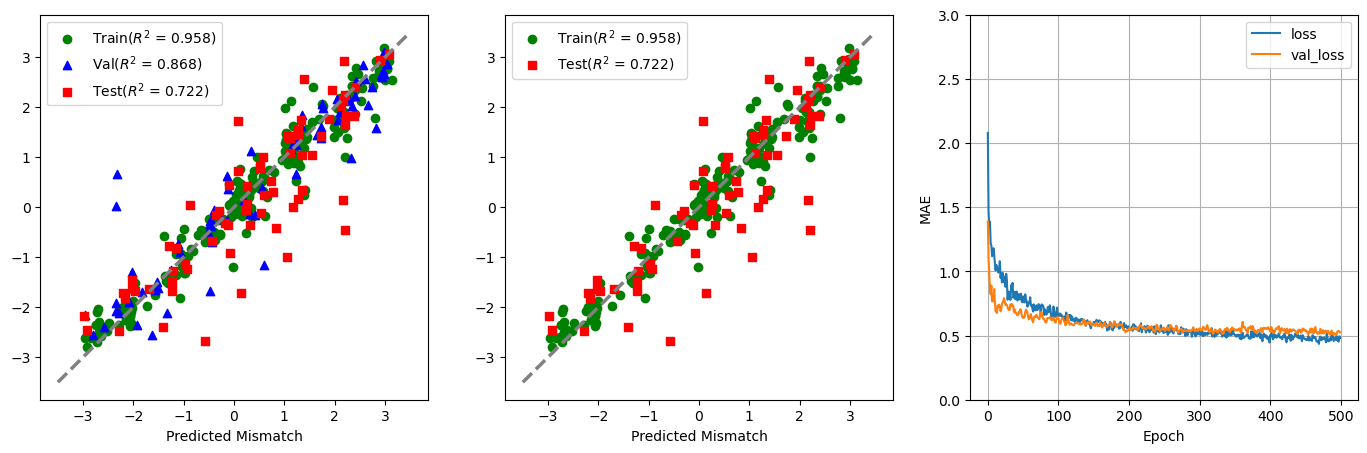

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [47]:
detailed_objective(study.best_trials[1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
R2 scores (train, val, test) =  0.9828975325810116 0.8615553503271844 0.7665511504536509
MAE values (train, val, test) =  0.16103275488803678 0.4316551711337933 0.552554403458441
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


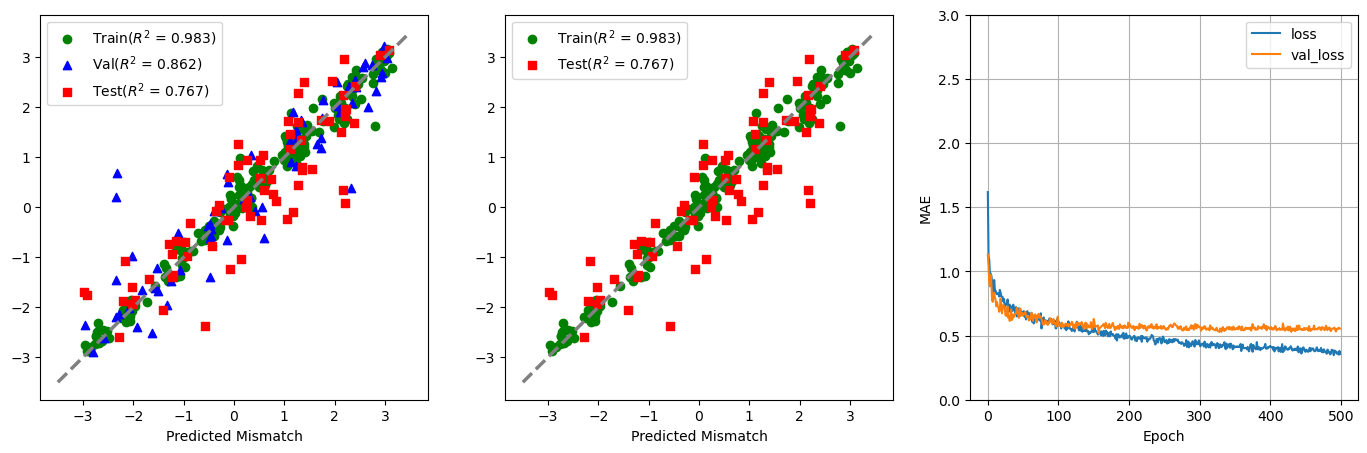

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [49]:
detailed_objective(study.best_trials[5])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
R2 scores (train, val, test) =  0.9833434624279344 0.8399874622816552 0.7865471636895056
MAE values (train, val, test) =  0.1667372884343693 0.4741727707081725 0.507752933517601
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


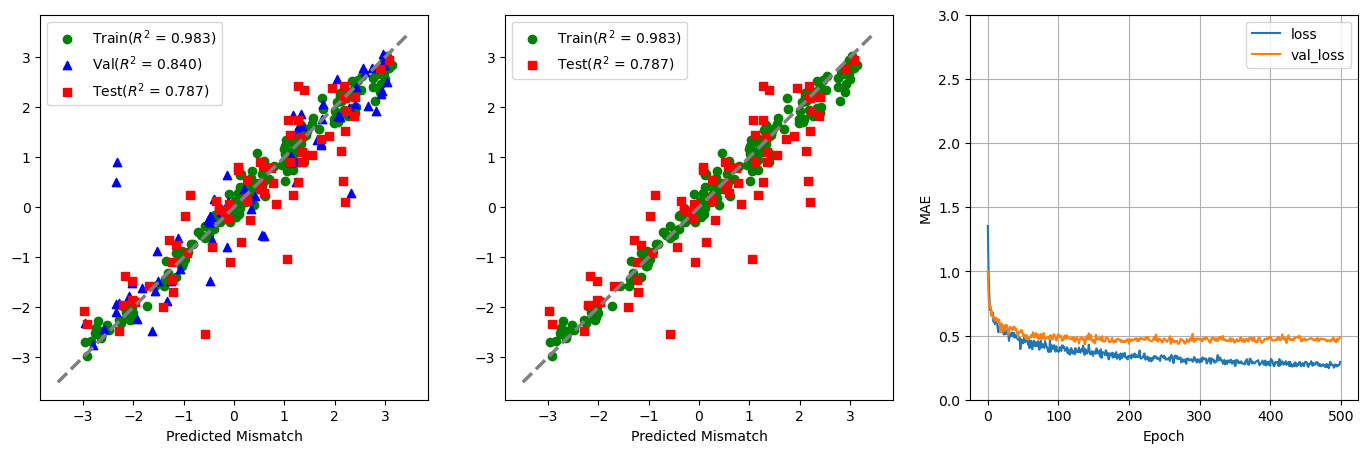

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [45]:
detailed_objective(study.best_trials[18])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R2 scores (train, val, test) =  0.9788752304887554 0.8551017156114509 0.768512740613877
MAE values (train, val, test) =  0.18512607217783206 0.4517419379484702 0.5529814215307525
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


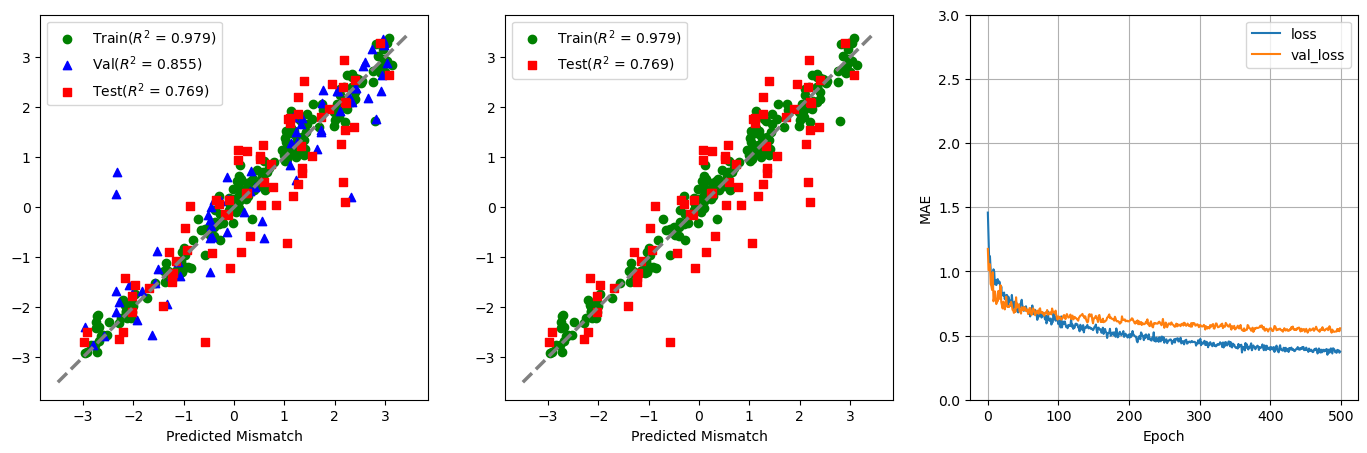

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [51]:
detailed_objective(study.best_trials[31])

In [1]:
## Load the best model

In [9]:
best_model_for_candidates = load_model('Results_Mismatch/optuna_model_BEST_31.keras')

In [10]:
candidates_785 = pd.read_excel('Results_Mismatch/descriptors_for_891_candidates.xlsx','without_Si')

In [11]:
X_785 = candidates_785[X.columns]

In [12]:
predicted_mismatch_785 = best_model_for_candidates.predict(X_785)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [65]:
pd.DataFrame(predicted_mismatch_785).to_csv('Results_Mismatch/pred_lattice_mismatch_FFNN_from_plots_without_Si.csv', index=False)